# Axon Segmentation Analysis of Whole-Brain Light-Sheet Images

## 1. Before Using this notebook:

### 1a. Install brainlit, and dependencies
### 1b. Write images to s3 using CloudReg
    - e.g. python -m cloudreg.scripts.create_precomputed_volumes --s3_input_paths /mnt/NAS/SmartSPIM_Data/2022_03_02/20220302_14_40_04_8529_destriped_DONE/Ex_561_Em_600_stitched --s3_output_paths  s3://smartspim-precomputed-volumes/2022_03_02/8529/Ch_561_v2  --voxel_size 1.83 1.83 2 --num_procs 24 --resample_iso False
### 1c. Make point annotations in neuroglancer to identify subvolumes for validation (and possible training)
    - instructions: https://neurodata.io/help/neuroglancer-pt-annotations/
        ,
    {
    "type":"pointAnnotation",
    "name": "val",
    "points": []
    }
### 1d. Update axon_data.py file

### \*Inputs\*

In [1]:
from brainlit.preprocessing import removeSmallCCs
from brainlit.BrainLine.util import (
    json_to_points,
    find_atlas_level_label,
    fold,
    setup_atlas_graph,
    get_atlas_level_nodes,
    download_subvolumes
)
from brainlit.BrainLine.data.axon_data import brain2paths, brain2centers
from brainlit.BrainLine.parse_ara import *
import xml.etree.ElementTree as ET
from brainlit.BrainLine.imports import *
from brainlit.BrainLine.apply_ilastik import ApplyIlastik, ApplyIlastik_LargeImage, plot_results, examine_threshold
from brainlit.BrainLine.analyze_results import AxonDistribution

%gui qt5

In [2]:
brainlit_path = Path(os.path.abspath(""))
brainlit_path = brainlit_path.parents[3]
print(f"Path to brainlit: {brainlit_path}")

for id in brain2paths.keys():
    if "base" in brain2paths[id].keys() and "val_info" in brain2paths[id].keys():
        base = brain2paths[id]["base"]
        if "http" in base:
            print(f"Sample {id}: http in basepath, which may cause write errors")

        try:
            url = brain2paths[id]["val_info"]["url"]
            layer = brain2paths[id]["val_info"]["layer"]
            pts = json_to_points(url)[layer]
        except:
            print(f"Sample {id}: Error with val_info")

        if "train_info" in brain2paths[id].keys():
            try:
                url = brain2paths[id]["train_info"]["url"]
                layer = brain2paths[id]["train_info"]["layer"]
                pts = json_to_points(url)[layer]
            except:
                print(f"Sample {id}: Error with train_info")
    else:
        print(f"Sample {id}: Does not conform to desired format")

Path to brainlit: /Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit
Sample atlas: Does not conform to desired format
Sample 2: Does not conform to desired format
Sample 1: Does not conform to desired format
Sample 3: Does not conform to desired format
Sample 4: Does not conform to desired format
Sample 8613: Does not conform to desired format
Sample 8604: Does not conform to desired format
Sample 8590_v2: Does not conform to desired format
Sample 8612: Does not conform to desired format
Sample 8788: Does not conform to desired format
Sample 11537: Does not conform to desired format


## 2. Download benchmark data

### \*Inputs\*

In [3]:
antibody_layer = "antibody"
background_layer = "background"
endogenous_layer = "endogenous"

brain = "test"  # brain ID
axon_data_dir = str(brainlit_path.parents[0]) + "/"  # path to directory where training/validation data should be stored
dataset_to_save = "val"  # train or val

### Setup paths

In [4]:
cvol_base = brain2paths[brain]["base"]
layer_names = [antibody_layer, background_layer, endogenous_layer]

for layer in [antibody_layer, background_layer, endogenous_layer]:
    try:
        CloudVolume(cvol_base + layer)
    except:
        print(f"Sample {id}: Layer {layer} not found in {cvol_base}")

if brain not in brain2paths.keys():
    raise ValueError(f"brain {brain} not an entry in brain2paths in axon_data.py file")

if f"{dataset_to_save}_info" not in brain2paths[
    brain
].keys() or dataset_to_save not in ["train", "val"]:
    raise ValueError(f"{dataset_to_save}_info not in brain2paths[{brain}].keys()")

### Download data

In [11]:
download_subvolumes(axon_data_dir, brain_id = brain, layer_names = layer_names, dataset_to_save = dataset_to_save, object_type="axon")

fg shape: (5697, 7336, 3900, 1) at [1830. 1830. 2000.]
bg shape: (5697, 7336, 3900, 1) at [1830. 1830. 2000.]
endo shape: (5697, 7336, 3900, 1) at [1830. 1830. 2000.]
[3] centers
Creating directory: /Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent//braintest/val/


Saving positive samples: 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


## 3. View downloaded data (optional)

### \*Inputs\*

In [12]:
fname = "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/braintest/val/2931_4163_1602.h5"  # path to file for viewing
scale = [1.8, 1.8, 2]  # voxel size in microns

In [14]:
with h5py.File(fname, "r") as f:
    pred = f.get("image_3channel")
    image_bg = pred[0, :, :, :]
    image_fg = pred[1, :, :, :]
    image_endo = pred[2, :, :, :]

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_fg, scale=scale)
viewer.add_image(image_bg, scale=scale)
viewer.add_image(image_endo, scale=scale)
viewer.scale_bar.visible = True
viewer.scale_bar.unit = "um"

## 4. Apply Ilastik to validation data

You will need to do two things:
- add annotations to the downloaded data (for me, partial labels on 3 of the z-slices using ilastik)
- apply axon segmentation model to the downloaded data. Results should be located in the same directory at the subvolumes, with the addition of "_Probabilities" appended to the file names: you can do this programmatically (below), or you can use the ilastik GUI (which is sometimes faster)

Note: make sure foreground/background labels are matched between the model and your annotations (for me, blue/1 =axon yellow/0=bg)

In [15]:
project_path = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/axon_segmentation.ilp"  # path to ilastik model to be used
ilastik_path = "/Applications/ilastik-1.4.0b21-OSX.app/Contents/ilastik-release/run_ilastik.sh"
brains = [brain]

In [16]:
applyilastik = ApplyIlastik(ilastk_path = ilastik_path, project_path = project_path, brains_path = axon_data_dir, brains = brains)
applyilastik.process_subvols()

running ilastik...: 100%|██████████| 3/3 [00:00<00:00, 115.10it/s]


## 5. Check results

Evaluating files: ['/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/braintest/val/2931_4163_1602_Probabilities.h5', '/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/braintest/val/2936_4167_1563_Probabilities.h5', '/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/braintest/val/2976_4255_1564_Probabilities.h5']
135 135
Threshold: 0.0 --- Total prec.: 0.05174396320429283, total rec.: 1.0 w/135/2474 total pos/neg samples in 3 images. F-score: 0.09839650145772594 
135 135
Threshold: 0.02 --- Total prec.: 0.05851755526657997, total rec.: 1.0 w/135/2474 total pos/neg samples in 3 images. F-score: 0.11056511056511056 
135 135
Threshold: 0.04 --- Total prec.: 0.07127771911298839, total rec.: 1.0 w/135/2474 total pos/neg samples in 3 images. F-score: 0.1330704780680138 
135 135
Threshold: 0.06 --- Total prec.: 0.08359133126934984, total rec.: 1.0 w/135/2474 total pos/neg samples in 3 images. F-score: 0.15428571428571428 
135 135
Threshold: 0.08 --- Tot

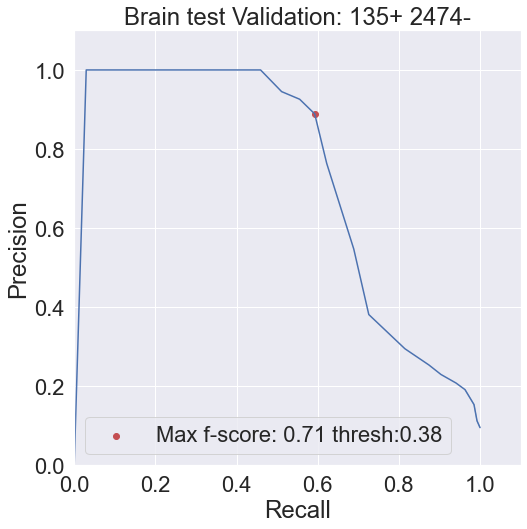

In [5]:
plot_results(data_dir=axon_data_dir, brain_id=brain, positive_channel=1, object_type="axon")

### If results above are not adequate improve the model and try again

In my case, I identify more subvolumes from the sample at hand using the same process as for validation data, and add it as training data to the model and retrain.


### Examine best threshold

In [6]:
examine_threshold(data_dir = axon_data_dir, brain_id = brain, threshold = 0.38, object_type="axon", positive_channel=1)

*************File: /Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/braintest/val/2931_4163_1602_Probabilities.h5*********
/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/braintest/val/2931_4163_1602.h5: prec1.0 recall: 0.16666666666666666
*************File: /Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/braintest/val/2936_4167_1563_Probabilities.h5*********
/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/braintest/val/2936_4167_1563.h5: prec0.6428571428571429 recall: 0.391304347826087
*************File: /Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/braintest/val/2976_4255_1564_Probabilities.h5*********


## 6. Make annotation layers

### Transformed layers

In [ ]:
atlas_vol = CloudVolume(
    "precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017"
)
for layer in [
    antibody_layer,
    background_layer,
    "axon_mask",
]:  # axon_mask is transformed into an image because nearest interpolation doesnt work well after downsampling
    layer_path = brain2paths[brain]["base"] + layer + "_transformed"
    info = CloudVolume.create_new_info(
        num_channels=1,
        layer_type="image",
        data_type="uint16",  # Channel images might be 'uint8'
        encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
        resolution=atlas_vol.resolution,  # Voxel scaling, units are in nanometers
        voxel_offset=atlas_vol.voxel_offset,
        chunk_size=[32, 32, 32],  # units are voxels
        volume_size=atlas_vol.volume_size,  # e.g. a cubic millimeter dataset
    )
    vol_mask = CloudVolume(layer_path, info=info)
    vol_mask.commit_info()

## 7. Apply ilastik to whole image:

### \* Inputs \*

You can use the notebook code below or the script using `axon_segment_image.py`

In [8]:
threshold = 0.38  # threshold to use for ilastik
data_dir = axon_data_dir + "brain_temp/" # data_dir = "/data/tathey1/matt_wright/brain_temp/"  # directory to store temporary subvolumes for segmentation

# Ilastik will run in "headless mode", and the following paths are needed to do so:
ilastik_path = "/Applications/ilastik-1.4.0b21-OSX.app/Contents/ilastik-release/run_ilastik.sh" # "/data/tathey1/matt_wright/ilastik/ilastik-1.4.0rc5-Linux/run_ilastik.sh"  # path to ilastik executable
ilastik_project = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/axon_segmentation.ilp" # "/data/tathey1/matt_wright/ilastik/model1/axon_segmentation.ilp"  # path to ilastik project


max_coords = [3072, 4352, 1792] #max coords or -1 if you want to process everything along that dimension
ncpu = 1 #16  # number of cores to use for detection
chunk_size = [256, 256, 256]#[256, 256, 300]

In [9]:
layer_names = [antibody_layer, background_layer, endogenous_layer]
alli = ApplyIlastik_LargeImage(ilastik_path = ilastik_path, ilastik_project=ilastik_project, ncpu=ncpu, object_type="axon")
alli.apply_ilastik_parallel(brain_id=brain, layer_names=layer_names, threshold=threshold, data_dir=data_dir, chunk_size=chunk_size, max_coords=max_coords)
alli.collect_axon_results(brain_id = brain, ng_layer_name="127.0.0.1:9010")

Processing: precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/brainlit/BrainLine/data/example/antibody with shape (5697, 7336, 3900, 1) at threshold 0.38
Creating directory: /Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brain_temp/


corner chunks:   0%|          | 0/15 [00:00<?, ?it/s]









Downloading:   0%|          | 0/8 [00:00<?, ?it/s]























































































Downloading:   0%|          | 0/8 [00:00<?, ?it/s]
























































































Downloading:   0%|          | 0/8 [00:00<?, ?it/s]

























































































Downloading:   0%|          | 0/8 [00:00<?, ?it/s]


























































































Downloading:   0%|          | 0/8 [00:00<?, ?it/s]



























































































Downloading:   0%|          | 0/8 [00:00<?, ?it/s]















































































































Downloading:   0%|          | 0/8 [00:00<?, ?it/s]


























{'dimensions': {'x': [1.83e-06, 'm'], 'y': [1.83e-06, 'm'], 'z': [2e-06, 'm']}, 'position': [2925.333740234375, 4195.89306640625, 1600.5], 'crossSectionScale': 0.5197493674168143, 'projectionScale': 8192, 'layers': [{'type': 'image', 'source': 'precomputed://http://127.0.0.1:9010/antibody', 'tab': 'source', 'shaderControls': {'normalized': {'range': [0, 2119]}}, 'name': '127.0.0.1:9010'}, {'type': 'segmentation', 'source': 'precomputed://http://127.0.0.1:9010/axon_mask', 'name': 'axon_mask'}], 'jsonStateServer': 'https://json.neurodata.io/v1', 'selectedLayer': {'layer': '127.0.0.1:9010', 'visible': True}, 'layout': 'xy', 'selection': {'layers': {'soma_val': {'annotationId': '425b67dbae3c132a8e4e5157a6a29acc885de35f', 'annotationSource': 0, 'annotationSubsource': 'default'}}}, 'partialViewport': [0, 0, 1, 1]}
Viz link with segmentation: https://viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=PD_0gXY0_aL0CQ


## 8. Register volume and transform data to atlas space using CloudReg

### 8a. You need to find an initial affine alignment using cloudreg.scripts.registration.get_affine_matrix. For example: 



A link to the ARA parcellation is:

`precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017`

And some python commands to help with affine alignment is:

```
from cloudreg.scripts.registration import get_affine_matrix
get_affine_matrix([1,1,1], [15,0,0], "PIR", "RAI", 1.15, "precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017")
```

### 8b. Run registration using cloudreg.scripts.registration. For example:

```
python -m cloudreg.scripts.registration -input_s3_path precomputed://s3://smartspim-precomputed-volumes/2022_11_01/8790/Ch_561 --output_s3_path precomputed://s3://smartspim-precomputed-volumes/2022_11_01/8790/atlas_to_target --atlas_s3_path https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_50um/average_50um --parcellation_s3_path https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017 --atlas_orientation PIR -orientation RAI --rotation 0 0 0 --translation 0 0 0 --fixed_scale 1.2 -log_s3_path precomputed://s3://smartspim-precomputed-volumes/2022_11_01/8790/atlas_to_target --missing_data_correction True --grid_correction False --bias_correction True --regularization 5000.0 --iterations 3000 --registration_resolution 100
```

### 8c. Transform segmentation to atlas space using CloudReg

```
python -m cloudreg.scripts.transform_data --target_layer_source precomputed://s3://smartspim-precomputed-volumes/2022_11_03/8589/axon_mask --transformed_layer_source precomputed://s3://smartspim-precomputed-volumes/2022_11_03/8589/axon_mask_transformed --affine_path /mnt/NAS/Neuroglancer\ Data/2021_11_03/8589/8589_Ch_561_registration/downloop_1_A.mat  --velocity_path /mnt/NAS/Neuroglancer\ Data/2021_11_03/8589/8589_Ch_561_registration/downloop_1_v.mat
```

This will write a layer to s3 with the transformed axon mask. The s3 path to this layer should be added to `axon_data.py` under the `axon_mask_transformed` key. Then the code below, or `axon_brainrender.py`, can be used to visualize the data.

In [ ]:
python -m cloudreg.scripts.transform_data --target_layer_source precomputed://file:///cis/home/tathey/projects/mouselight/brainlit/brainlit/BrainLine/data/example/axon_mask --transformed_layer_source precomputed://file:///cis/home/tathey/projects/mouselight/brainlit/brainlit/BrainLine/data/example/axon_mask_transformed --affine_path /cis/home/tathey/projects/mouselight/brainlit/brainlit/BrainLine/data/example/downloop_1_A.mat  --velocity_path /cis/home/tathey/projects/mouselight/brainlit/brainlit/BrainLine/data/example/downloop_1_v.mat

## 10. View coronal heat maps

### \*Inputs\*

In [2]:
# A couple useful lists of samples
brain_ids_good = ["8650", "8788", "8613", "8589", "8786"]
brain_ids_select = ["8650", "8788"]
brain_ids = ["8650", "8649", "8589", "8590", "8613"]

colors = {
    "tph2 gad2": "red",
    "tph2 vglut3": "green",
}  # colors for different genotypes
fold_on = True

In [4]:
ad = AxonDistribution(brain_ids = brain_ids)

for z in np.arange(100, 1300, 700):
    ad.napari_coronal_section(z= z, subtype_colors = colors, fold_on = fold_on)

Downloading: 100%|██████████| 1800/1800 [00:09<00:00, 197.76it/s]


(800, 570)
float64
(800, 570)
uint64
(800, 570)
uint64


Downloading: 100%|██████████| 1800/1800 [00:11<00:00, 161.29it/s]


(800, 570)
float64
(800, 570)
uint64
(800, 570)
uint64


## 11. Collect region based results

Use `axon_collect_results.py`

## 12. Display bar charts

### \*Inputs\*

In [ ]:
wholebrain_results_dir = ""  #

brains = [
    # "3",
    # "4",
    "8613",
    # "8604",
    "8650",
    "8589",
    # "8590",
    # "8649",
    "8788",
    "8786",
    "11537",
    "8790",
]  # list of sample IDs to be shown

regions = [
    688,  # cerebral cortex
    698,  # olfactory areas
    1089,  # hippocampal formation
    # 583, # claustrum
    477,  # striatum
    # 803, # pallidum
    351,  # bed nuclei of stria terminalis
    # 703, #cortical subplate
    1097,  # hypothalamus
    549,  # thalamus
    186,  # lateral habenula
    519,  # cerebellar nuclei
    313,  # midbrain
    1065,  # hindbrain
]  # allen atlas region IDs to be shown
# see: https://connectivity.brain-map.org/projection/experiment/480074702?imageId=480075280&initImage=TWO_PHOTON&x=17028&y=11704&z=3

composite_regions = {
    "Amygdalar Nuclei": [131, 295, 319, 780]
}  # Custom composite allen regions where key is region name and value is list of allen regions


level = "coarse"  # coarse or fine, dictates whether the regions specified above will be shown (coarse), or their subregions (fine)

if level not in ["coarse", "fine"]:
    raise ValueError(f"level must be coarse or fine, not {level}")

### Setup data

In [ ]:
counts = {}
genotypes = []
for brain_id in brains:
    genotypes.append(brain2paths[brain_id]["genotype"])
for unq_gene in set(genotypes):
    count = 0
    for genotype in genotypes:
        if genotype == unq_gene:
            count += 1
    counts[unq_gene] = count


quantification_dicts = {}

for brain in brains:
    path = (
        "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/wholebrain_results/wholebrain_"
        + brain
        + ".pkl"
    )
    with open(path, "rb") as f:
        quantification_dict = pickle.load(f)

    quantification_dicts[brain] = quantification_dict

In [ ]:
G = setup_atlas_graph()
max_level = 0

for node in G.nodes:
    if G.nodes[node]["level"] > max_level:
        max_level = G.nodes[node]["level"]
    for brain in quantification_dicts.keys():
        G.nodes[node][brain + " axon"] = 0
        G.nodes[node][brain + " total"] = 0

In [ ]:
# add data
i_test = 0
print(f"Max level: {max_level}")
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " axon"])
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " total"])
for brain, quantification_dict in quantification_dicts.items():
    for key in quantification_dict.keys():
        if key in G.nodes:
            G.nodes[key][brain + " axon"] = G.nodes[key][brain + " axon"] + float(
                quantification_dict[key][1]
            )
            G.nodes[key][brain + " total"] = G.nodes[key][brain + " total"] + float(
                quantification_dict[key][0]
            )
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " axon"])
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " total"])

# add child data to parent data
for brain in quantification_dicts.keys():
    for lvl in range(max_level, 0, -1):
        for node in G.nodes:
            if G.nodes[node]["level"] == lvl:
                parent = list(G.in_edges(node))[0][0]
                G.nodes[parent][brain + " axon"] = (
                    G.nodes[parent][brain + " axon"] + G.nodes[node][brain + " axon"]
                )
                G.nodes[parent][brain + " total"] = (
                    G.nodes[parent][brain + " total"] + G.nodes[node][brain + " total"]
                )
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " axon"])
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " total"])

In [ ]:
totals = {}

for brain in quantification_dicts.keys():
    total = 0
    for node in G.nodes:
        total += G.nodes[node][brain + " axon"]
    totals[brain] = total

axon_vols = []
axon_denss = []
axon_denss_norm = []
gene = []
subregion_name = []
region_name = []
brain_ids = []
for region in regions:
    print(f"Populating: " + G.nodes[region]["name"])
    # choose level here
    if level == "fine":
        children = list(G.successors(region))
    elif level == "coarse":
        children = [region]
    else:
        raise ValueError(f"level must be coarse or fine, not {level}")

    for child in children:
        for brain in quantification_dicts.keys():
            drn_norm_factor = (
                G.nodes[872][brain + " axon"] / G.nodes[872][brain + " total"]
            )

            if drn_norm_factor == 0:
                print(f"Warning: brain {brain} has no projection in DRN")
                drn_norm_factor = 1

            axon_vol = G.nodes[child][brain + " axon"]
            total_vol = G.nodes[child][brain + " total"]
            if total_vol == 0 and axon_vol == 0:
                axon_denss.append(0)
                axon_denss_norm.append(0)
            elif total_vol == 0:
                raise ValueError("positive axon volume in zero volume region?")
            else:
                dens = axon_vol / total_vol
                axon_denss.append(dens * 100)
                axon_denss_norm.append(dens / drn_norm_factor)

            axon_vols.append(axon_vol / totals[brain] * 100)
            gene.append(
                brain2paths[brain]["genotype"]
                + f" (n={counts[brain2paths[brain]['genotype']]})"
            )
            subregion_name.append(G.nodes[child]["name"])
            region_name.append(G.nodes[region]["name"])
            brain_ids.append(brain)

for region_component_name in composite_regions.keys():
    print(f"Populating: " + region_component_name)
    region_components = composite_regions[region_component_name]
    for brain in quantification_dicts.keys():
        drn_norm_factor = G.nodes[872][brain + " axon"] / G.nodes[872][brain + " total"]
        if drn_norm_factor == 0:
            print(f"Warning: brain {brain} has no projection in DRN")
            drn_norm_factor = 1

        axon_vol = 0
        total_vol = 0

        for region_component in region_components:
            axon_vol += G.nodes[region_component][brain + " axon"]
            total_vol += G.nodes[region_component][brain + " total"]

        if total_vol == 0 and axon_vol == 0:
            axon_denss.append(0)
            axon_denss_norm.append(0)
        elif total_vol == 0:
            raise ValueError("positive axon volume in zero volume region?")
        else:
            dens = axon_vol / total_vol
            axon_denss.append(dens * 100)
            axon_denss_norm.append(dens / drn_norm_factor)

        axon_vols.append(axon_vol / totals[brain] * 100)
        gene.append(
            brain2paths[brain]["genotype"]
            + f" (n={counts[brain2paths[brain]['genotype']]})"
        )
        subregion_name.append(region_component_name)
        region_name.append(region_component_name)
        brain_ids.append(brain)


d = {
    "Percent Total Axon Volume (%)": axon_vols,
    "Axon Density (%)": axon_denss,
    "Normalized Axon Density": axon_denss_norm,
    "Gene": gene,
    "Subregion": subregion_name,
    "Region": region_name,
    "Brain ID": brain_ids,
}
df = pd.DataFrame(data=d)

### Make bar chart

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(26, 13))
sns.set(font_scale=2)

test = "Mann-Whitney"
# test = "t-test_ind"
correction = "fdr_by"

# density
fig_args = {
    "y": "Axon Density (%)",
    "x": "Subregion",
    "hue": "Gene",
    "data": df,
}
pairs = []
unq_subregions = []
for subregion in subregion_name:
    if subregion not in unq_subregions:
        unq_subregions.append(subregion)


genes = df["Gene"].unique()
gene_pairs = [(a, b) for idx, a in enumerate(genes) for b in genes[idx + 1 :]]

for gene_pair in gene_pairs:
    for subregion in unq_subregions:
        pairs.append(
            (
                (subregion, gene_pair[0]),
                (subregion, gene_pair[1]),
            )
        )


annotator = Annotator(axes[0], pairs, **fig_args)
fig_args = {
    "x": "Axon Density (%)",
    "y": "Subregion",
    "hue": "Gene",
    "data": df,
}


sns.set(font_scale=2)
strpplot = sns.barplot(ax=axes[0], orient="h", **fig_args)
strpplot.set_xscale("log")

annotator.configure(
    test=test, text_format="star", loc="outside", comparisons_correction=correction
)
annotator.new_plot(strpplot, orient="h", plot="barplot", **fig_args)
annotator.apply_and_annotate()

# percent total
fig_args = {
    "y": "Percent Total Axon Volume (%)",
    "x": "Subregion",
    "hue": "Gene",
    "data": df,
}
pairs = []
unq_subregions = []
for subregion in subregion_name:
    if subregion not in unq_subregions:
        unq_subregions.append(subregion)


for gene_pair in gene_pairs:
    for subregion in unq_subregions:
        pairs.append(
            (
                (subregion, gene_pair[0]),
                (subregion, gene_pair[1]),
            )
        )


annotator = Annotator(axes[1], pairs, **fig_args)
fig_args = {
    "x": "Percent Total Axon Volume (%)",
    "y": "Subregion",
    "hue": "Gene",
    "data": df,
}

strpplot = sns.barplot(ax=axes[1], orient="h", **fig_args)
strpplot.set_xscale("log")

annotator.configure(
    test=test, text_format="star", loc="outside", comparisons_correction=correction
)
annotator.new_plot(strpplot, orient="h", plot="barplot", **fig_args)
annotator.apply_and_annotate()

fig.tight_layout()

### Compare distributions with PCA

In [ ]:
X = []
brain_ids = []
genotypes = []

for i, brain in enumerate(brains):
    print(brain)
    region_order = list(df.loc[df["Brain ID"] == brain]["Region"])

    if i == 0:
        standard_region_order = region_order
    elif standard_region_order != region_order:
        raise ValueError(f"Different region order for brain {brain}")

    distrib = list(df.loc[df["Brain ID"] == brain]["Percent Total Axon Volume (%)"])
    X.append(distrib)

    brain_ids.append(brain)
    genotypes.append(brains[brain])

X = np.array(X)

pca = PCA(n_components=2)
X_2 = pca.fit_transform(X)

df_pca = {
    "PC 1": X_2[:, 0],
    "PC 2": X_2[:, 1],
    "Genotype": genotypes,
    "Brain ID": brain_ids,
}
df_pca = pd.DataFrame(data=df_pca)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(data=df_pca, x="PC 1", y="PC 2", hue="Genotype", ax=ax)


for i in range(df_pca.shape[0]):
    plt.text(
        x=df_pca["PC 1"][i] + 0.03,
        y=df_pca["PC 2"][i] + 0.03,
        s=df_pca["Brain ID"][i],
        fontdict=dict(color="black", size=20),
    )

plt.title(
    f"Projection Distribution PCA with Explained Variance: {pca.explained_variance_ratio_}"
)

## 13. Compare to Allen

### \* Inputs \*

In [ ]:
allen_regions = [
    315,
    698,
    1089,
    703,
    477,
    803,
    549,
    1097,
    313,
    771,
    354,
    512,
]  # allen atlas region IDs to be shown https://connectivity.brain-map.org/projection/experiment/480074702?imageId=480075280&initImage=TWO_PHOTON&x=17028&y=11704&z=3

#### Subregion

In [ ]:
axon_denss = []
gene = []
subregion_name = []
region_name = []
subregions_list = []
for region in allen_regions:
    print(f"Populating: " + G.nodes[region]["name"])
    children = list(G.successors(region))
    for child in children:
        if child not in subregions_list:
            subregions_list.append(child)

        for brain in quantification_dicts.keys():
            if (
                G.nodes[child][brain + " total"] == 0
                and G.nodes[child][brain + " axon"] == 0
            ):
                axon_denss.append(0)
            elif G.nodes[child][brain + " total"] == 0:
                raise ValueError("positive axon volume in zero volume region?")
            else:
                axon_denss.append(
                    G.nodes[child][brain + " axon"] / G.nodes[child][brain + " total"]
                )

            if brain in ["B", "R"]:
                gene.append(brain)
            subregion_name.append(G.nodes[child]["name"])

    region_name.append(G.nodes[region]["name"])

tree = ET.parse(brainlit_path / "brainlit" / "lsm_analysis" / "data" / "sert_exp.xml")
root = tree.getroot()
root.tag
for child in root:
    for i, entry in enumerate(child):
        for item in entry:
            if item.tag == "structure-id":
                region = int(item.text)
            elif item.tag == "hemisphere-id":
                hemi = int(item.text)
            elif item.tag == "is-injection":
                inject = item.text
            elif item.tag == "projection-density":
                density = float(item.text)
        if region in subregions_list and hemi == 3 and inject == "false":
            name = G.nodes[region]["name"]
            print(f"id: {region} hemi: {hemi}, density: {density}, name: {name}")
            subregion_name.append(name)
            gene.append("Allen")
            axon_denss.append(density)


d = {"Axon Density": axon_denss, "Gene": gene, "Subregion": subregion_name}
df = pd.DataFrame(data=d)

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
fig.suptitle("Detected Output Axons")

sns.barplot(x="Axon Density", y="Subregion", hue="Gene", data=df)
axes.set_title("Density")

fig.tight_layout()

#### Region

In [ ]:
axon_denss = []
axon_vols = []
gene = []
region_name = []
for region in allen_regions:
    print(f"Populating: " + G.nodes[region]["name"])
    for brain in quantification_dicts.keys():
        if (
            G.nodes[region][brain + " total"] == 0
            and G.nodes[region][brain + " axon"] == 0
        ):
            axon_denss.append(0)
        elif G.nodes[region][brain + " total"] == 0:
            raise ValueError("positive axon volume in zero volume region?")
        else:
            axon_denss.append(
                G.nodes[region][brain + " axon"] / G.nodes[region][brain + " total"]
            )
            axon_vols.append(
                G.nodes[region][brain + " axon"]
                * np.product([1.82, 1.82, 2])
                * 10 ** (-9)
            )

        if brain in ["B", "R"]:
            gene.append("Sample " + brain)

        region_name.append(G.nodes[region]["name"])

tree = ET.parse(brainlit_path / "brainlit" / "lsm_analysis" / "data" / "sert_exp.xml")
root = tree.getroot()
root.tag
for child in root:
    for i, entry in enumerate(child):
        for item in entry:
            if item.tag == "structure-id":
                region = int(item.text)
            elif item.tag == "hemisphere-id":
                hemi = int(item.text)
            elif item.tag == "is-injection":
                inject = item.text
            elif item.tag == "projection-density":
                density = float(item.text)
            elif item.tag == "projection-volume":
                volume = float(item.text)
        if region in allen_regions and hemi == 3 and inject == "false":
            name = G.nodes[region]["name"]
            print(
                f"id: {region} hemi: {hemi}, density: {density}, volume: {volume}, name: {name}"
            )
            region_name.append(name)
            gene.append("Allen")
            axon_denss.append(density)
            axon_vols.append(volume)


d = {
    "Axon Density": axon_denss,
    "Axon Volume ($mm^3$)": axon_vols,
    "Gene": gene,
    "Region": region_name,
}
df = pd.DataFrame(data=d)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Comparing Axon Volumes to Allen Experiment")

sns.set(font_scale=2)

sns.barplot(
    ax=axes[0],
    x="Axon Density",
    y="Region",
    hue="Gene",
    order=list(
        df[df["Gene"] == "Allen"]
        .sort_values("Axon Density", ascending=False)
        .loc[:, "Region"]
    ),
    data=df,
)
# axes[0].set_title("Density")

sns.barplot(
    ax=axes[1],
    x="Axon Volume ($mm^3$)",
    y="Region",
    hue="Gene",
    order=list(
        df[df["Gene"] == "Allen"]
        .sort_values("Axon Density", ascending=False)
        .loc[:, "Region"]
    ),
    data=df,
)
# axes[1].set_title("Axon Volume")

fig.tight_layout()

In [53]:
from brainlit.BrainLine.util import find_sample_names
import h5py
import numpy as np

base_dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/"

brains = ["3", "4", "887", "8589", "8590", "8590_v2", "8604", "8612", "8613", "8649", "8650", "8786", "8788", "8790", "11537"]

for brain in brains:
    brain_dir = base_dir + "brain" +  brain
    files = find_sample_names(brain_dir, dset="", add_dir=True)
    for file in files:
        with h5py.File(file, "r") as f:
            key = list(f.keys())[0]
            print(key)
        #     image = np.array(f.get(key))
        # image = image[[1, 0, 2],:,:,:]
        # with h5py.File(file, "w") as f:
        #     dset = f.create_dataset(key, data=image)


image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2channel
image_2cha

In [63]:

with h5py.File("/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain3/train_0-image_2channel_Labels.h5", "r") as f:
    key = list(f.keys())[0]
    image = np.array(f.get(key))
    print(image.shape)
    print(np.sum(image))

(1, 99, 99, 99)
723


In [64]:
import numpy as np
image = np.load("/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain3/train_0-image_2channel_Labels.npy")
print(image.shape)
print(np.sum(image))


(1, 99, 99, 99)
723


In [72]:
dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain4/train/"
for file in os.listdir(dir):
    if "Labels" in file:
        file = dir + file
        print(file)
        with h5py.File(file, "r") as f:
            key = list(f.keys())[0]
            image = np.array(f.get(key))
        print(np.sum(image))
        # npy_file = file.split(".")[0] + ".npy"
        # np.save(npy_file, image)

/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain4/train/train_3-image_2channel_Labels.npy


OSError: Unable to open file (file signature not found)

In [69]:
file = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain3/train/train_31-image_2channel_Labels.h5"
with h5py.File(file, "r") as f:
    key = list(f.keys())[0]
    image = np.array(f.get(key))
npy_file = file.split(".")[0] + ".npy"
np.save(npy_file, image)

In [2]:
vol = CloudVolume("precomputed://https://dlab-colm.neurodata.io/2022_10_24/8788/axon_mask")

In [17]:
# reg_sub = vol[int(256*11/8):int(256*12/8),int(256*16/8):int(256*17/8), int(256*6:256*7/8)]
atlas_vol = CloudVolume("precomputed://s3://smartspim-precomputed-volumes/2022_03_10/8531/atlas_to_target")
info = CloudVolume.create_new_info(
    num_channels=1,
    layer_type="segmentation",
    data_type="uint64",  # Channel images might be 'uint8'
    encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
    resolution=atlas_vol.resolution,  # Voxel scaling, units are in nanometers
    voxel_offset=atlas_vol.voxel_offset,
    chunk_size=[32,32,32],  # units are voxels
    volume_size=atlas_vol.volume_size,  # e.g. a cubic millimeter dataset
)
vol_mask = CloudVolume("precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/brainlit/BrainLine/data/example/atlas_to_target", info=info, compress=False)
vol_mask.commit_info()

In [18]:
vol_mask[int(256*11/8):int(256*12/8),int(256*16/8):int(256*17/8), 256*6:256*7] = atlas_vol[int(256*11/8):int(256*12/8),int(256*16/8):int(256*17/8), 256*6:256*7]

Uploading: 100%|██████████| 8/8 [00:00<00:00, 59.93it/s]


In [21]:
subvol = np.load("/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/brainlit/BrainLine/data/example/axon_mask_transformed/subvol.npy")
vol = CloudVolume("precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/brainlit/BrainLine/data/example/axon_mask_transformed", compress=False)



In [22]:
vol[30*32:32*32,7*32:9*32,16*32:18*32] = subvol

Uploading: 100%|██████████| 8/8 [00:00<00:00, 63.73it/s]
